## Assignment 7
Grou 3p members :Claudia Córdova Yamauchi
Fátima Trujillo Quiñe
Mauricio Flores Jiménez
Reynaldo Padilla Milla
Vania amarena

In [1]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }a
</style>
"""))

In [2]:
#Required Libraries
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import chardet

import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Point, LineString
import folium
from folium import Marker, GeoJson
from folium.plugins import MarkerCluster, HeatMap


In [4]:
# 1. Import data from data_dengue.csv
dengue_data = pd.read_csv('../../_data/data_dengue_peru.csv', low_memory=False, converters={'Casos': lambda x: float(x.replace(',', '')) if x != '' else np.nan})

#Ubigeo is int64, I better change it to String
dengue_data['Ubigeo'] = dengue_data['Ubigeo'].astype(str)


In [5]:
# 2. Generating (and correcting) ubigeo codes for Departments and Provinces
dengue_data['Ubigeo'] = dengue_data['Ubigeo'].astype(str).str.zfill(6)
dengue_data['ubigeo_departamento'] = dengue_data['Ubigeo'].astype(str).str[:2]
dengue_data['ubigeo_provincia'] = dengue_data['Ubigeo'].astype(str).str[:4]


In [6]:
# Loading the shapefile for districts
district_shp = gpd.read_file('../../_data/LIMITE_DISTRITAL_2020_INEI/INEI_LIMITE_DISTRITAL.shp')
district_shp.crs


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
# 3. Use geopandas to plot the number of cases in 2021 by the district using a continuous legend. Do not forget to indicate the color of NA values. Mauricio

#  Filtering data for 2021 cases
dengue_2021 = dengue_data[dengue_data['Año'] == 2021]

dengue_2021bydistrict = dengue_2021.groupby('Ubigeo')['Casos'].sum().reset_index()

dengue_2021bydistrict_gdf = district_shp.merge(dengue_2021bydistrict, left_on='UBIGEO', right_on='Ubigeo', how='left')


<Axes: >

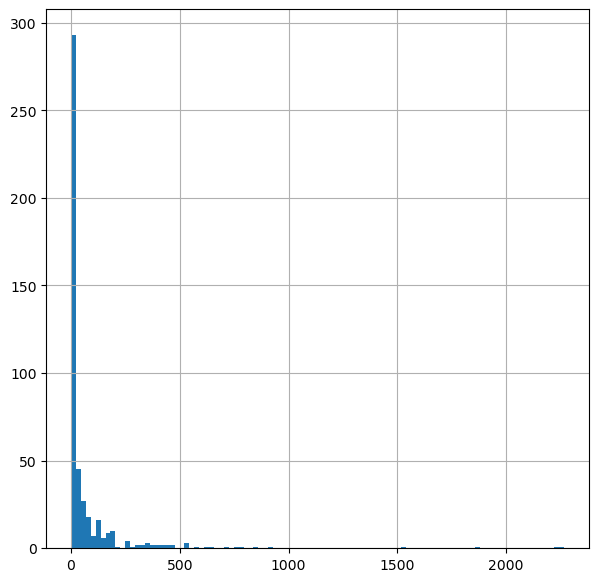

In [10]:
#Before plotting,always check the distribution
fig, ax = plt.subplots(figsize=(7, 7))
dengue_2021bydistrict["Casos"].hist(bins = 100)


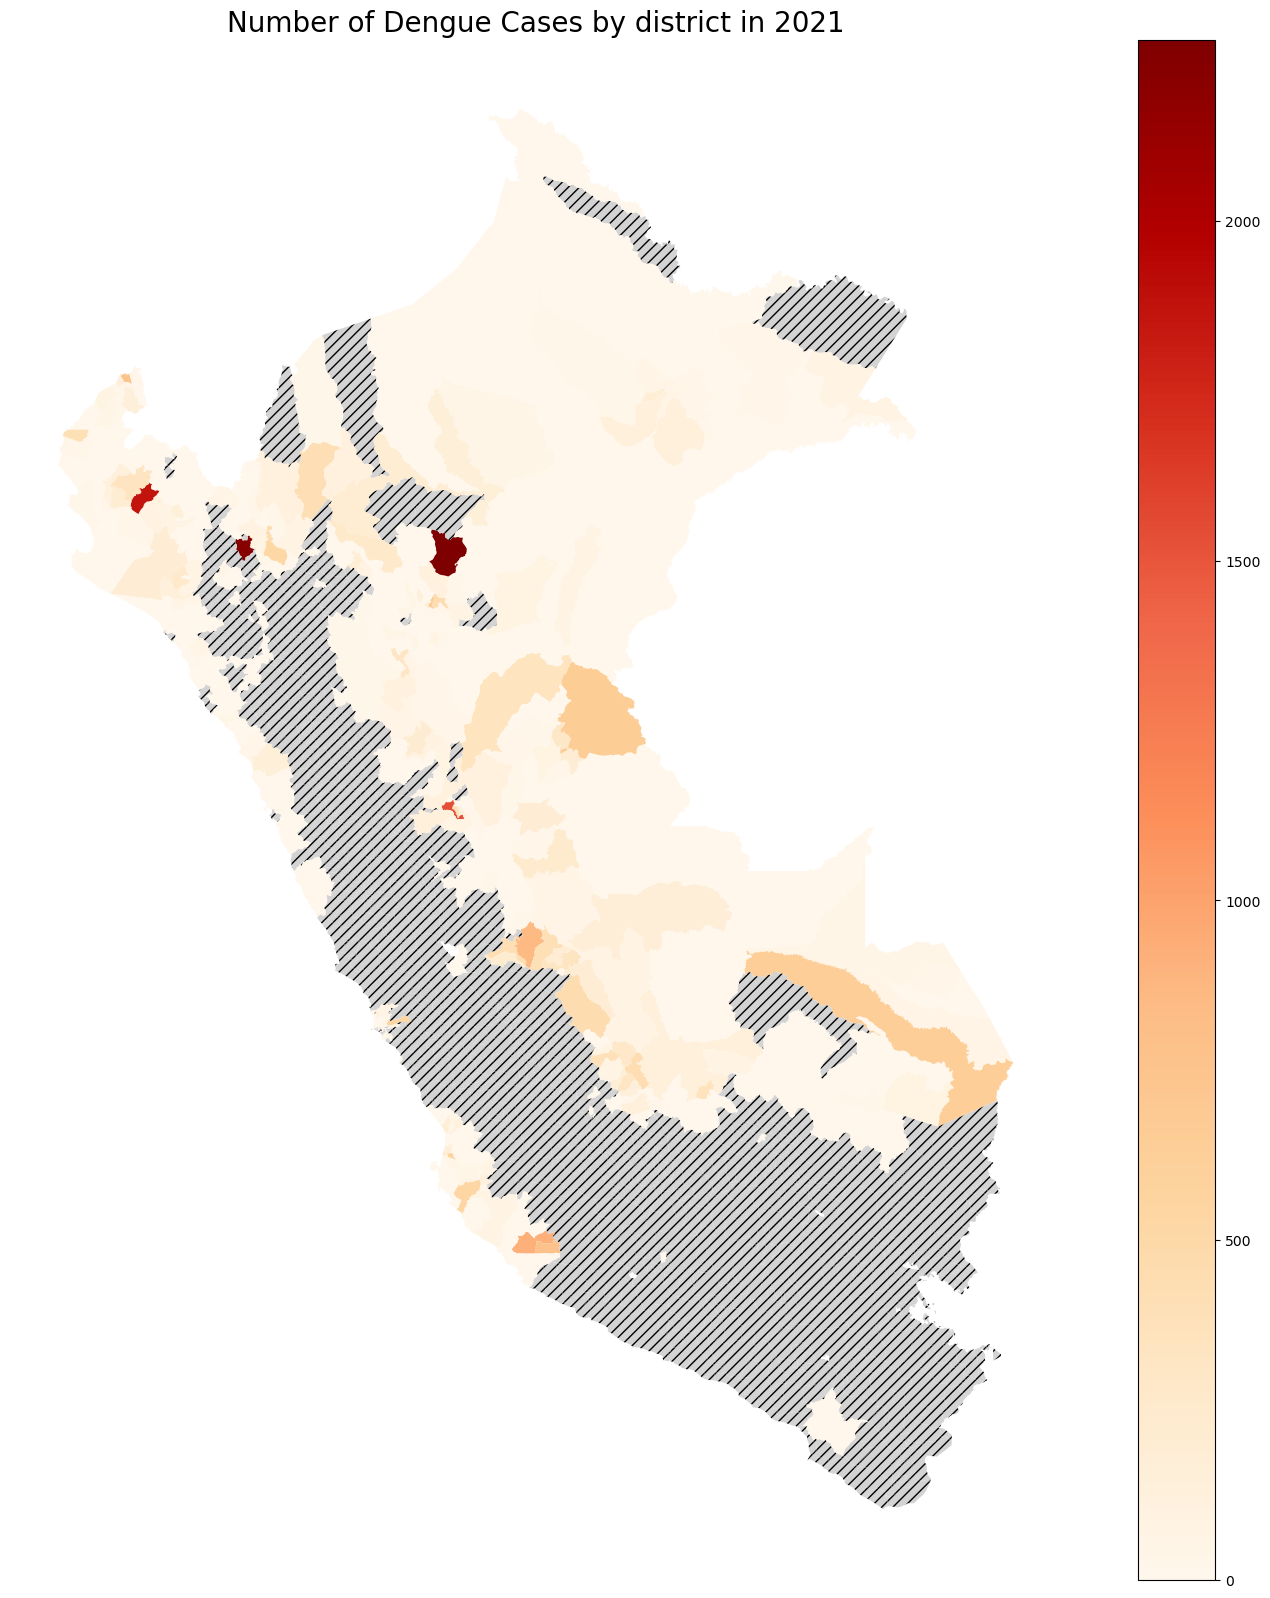

In [11]:
# Set up the plot
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

# Plot the map, specifying a color for NaN values (lightgrey stripes)
dengue_2021bydistrict_gdf.plot(column='Casos', cmap='OrRd', legend=True,
           	missing_kwds={"color": "lightgrey", "label": "No data", "hatch": "///"},
           	ax=ax)

# Add a title and adjust the legend
ax.set_title('Number of Dengue Cases by district in 2021', fontsize=20)
ax.set_axis_off()  # Turn off the axis

plt.show()


In [12]:
# 4. Use geopandas to plot the number of cases in 2021 by the province using a continuous legend Claudia
# Aggregating number of cases by province
dengue_2021byprovince = dengue_2021.groupby('ubigeo_provincia')['Casos'].sum().reset_index()

# Using the dissolve method to aggregate geometries based on province code (Ubigeo) 196 provs
provinces_shp = district_shp.dissolve(by='IDPROV')

# Merging the aggregated cases data with the provinces geodataframe
dengue_2021byprovince_gdf = provinces_shp.merge(dengue_2021byprovince, left_on='IDPROV', right_on='ubigeo_provincia', how='left')

<Axes: >

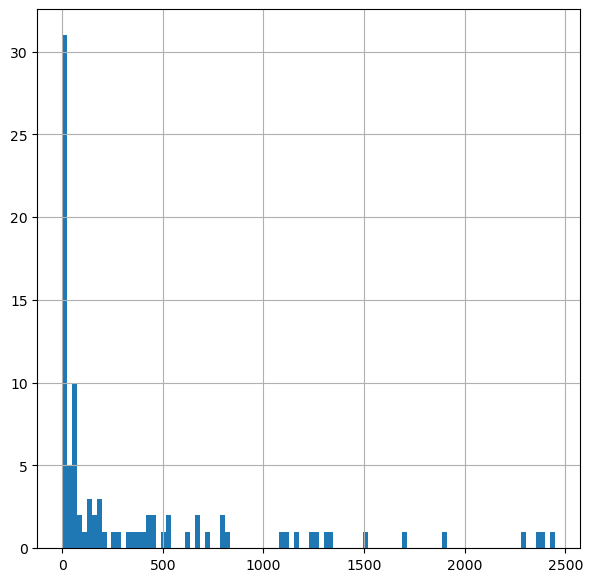

In [14]:
#Before plotting,always check the distribution
fig, ax = plt.subplots(figsize=(7, 7))
dengue_2021byprovince["Casos"].hist(bins = 100)


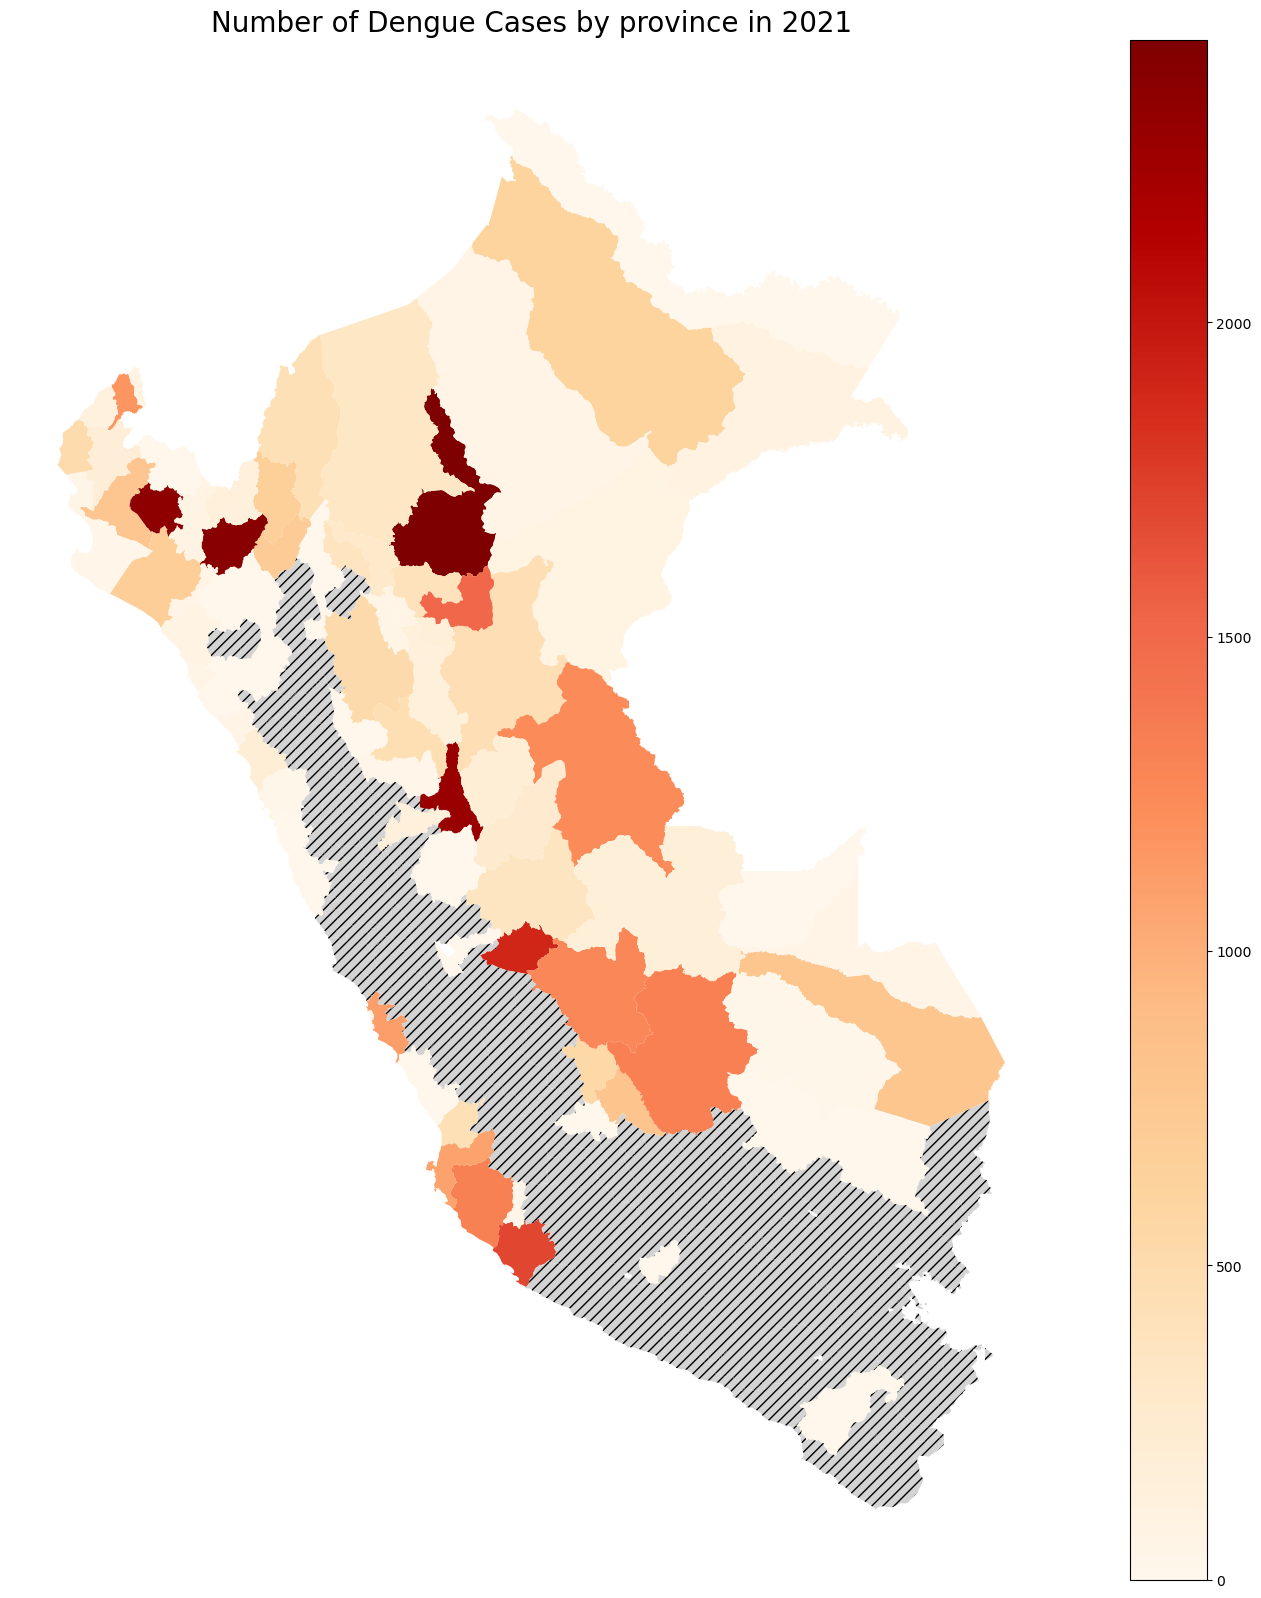

In [15]:
# Setting up the plot
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

# Ploting the map with a continuous color scale for the number of cases and lightgrey stripes for NA 
dengue_2021byprovince_gdf.plot(column='Casos', cmap='OrRd', legend=True,
            	missing_kwds={"color": "lightgrey", "label": "No data", "hatch": "///"},
            	ax=ax)

# Adding title
ax.set_title('Number of Dengue Cases by province in 2021', fontsize=20)
ax.set_axis_off()  # Turn off the axis

plt.show()


In [ ]:
# 5. Use geopandas to plot the number of cases by the department for all the years using subplots. 
# Every subplot for each year. Fátima



In [ ]:
# Group data by department and year
dengue_data_dep = dengue_data.groupby(['ubigeo_departamento', 'Departamento', 'Año',])['Casos'].sum().reset_index()
dengue_data_dep

In [ ]:
# Grouping the shp data by department and year
dept_shp = district_shp.dissolve( by = 'CCDD', as_index=False )
dept_shp = dept_shp[['CCDD', 'geometry','NOMBDEP']]

#Now, we want every region to be associated to a year, so we create complete dataframes with the combinations. This allows us to show the missing values every year

# Creating a DataFrame with unique years and departments (DPTO)
years = dengue_data_dep['Año'].unique()  # Unique years from dengue data
departments = dept_shp[['CCDD']]  # Unique departments from the shapefile

# Creating a DataFrame with the Cartesian product of departments and years
all_combinations = pd.MultiIndex.from_product([departments['CCDD'], years], names=['CCDD', 'Año']).to_frame(index=False)

# Merging with the dengue data
complete_dengue_dept = all_combinations.merge(dengue_data_dep, left_on=['CCDD', 'Año'], right_on=['ubigeo_departamento', 'Año'], how='left')

# Merging the geometry of the departments from the shapefile
dengue_dept_full = dept_shp[['CCDD', 'geometry']].merge(complete_dengue_dept, on='CCDD', how='right')

dengue_dept_full

In [ ]:
# 6. Use geopandas to plot the number of cases by the department for all 2021 quarters using subplots. 
# Every subplot for each quarter. Use a categorical legend with 5 bins. Vania




In [3]:
# Loading the data
dengue_data = pd.read_csv('../../_data/data_dengue_peru.csv', low_memory=False)



C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_41280\61817505.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data_dengue = pd.read_csv('../../_data/data_dengue_peru.csv')


,Año,Semana,Eventos o daños,Departamento,Distrito,Provincia,Ubigeo,Casos
0,2020,43,Dengue,CUSCO,MEGANTONI,LA CONVENCION,80914,2.0
1,2021,41,Dengue,MOQUEGUA,MOQUEGUA,MARISCAL NIETO,180101,NaN
2,2021,42,Dengue,MOQUEGUA,MOQUEGUA,MARISCAL NIETO,180101,NaN
3,2020,1,Dengue,CUSCO,MEGANTONI,LA CONVENCION,80914,0.0
4,2020,53,Dengue,CUSCO,MEGANTONI,LA CONVENCION,80914,2.0
...,...,...,...,...,...,...,...,...
172139,2021,49,Dengue,MADRE DE DIOS,MADRE DE DIOS,MANU,170203,NaN
172140,2021,49,Dengue,MADRE DE DIOS,TAHUAMANU,TAHUAMANU,170303,NaN
172141,2021,50,Dengue,MADRE DE DIOS,MADRE DE DIOS,MANU,170203,NaN
172142,2021,50,Dengue,MADRE DE DIOS,TAHUAMANU,TAHUAMANU,170303,NaN


In [4]:
# Correcting Ubigeo and generating ubigeo codes for Departments and Provinces
dengue_data['Ubigeo'] = dengue_data['Ubigeo'].astype(str).str.zfill(6)

dengue_data['ubigeo_departamento'] = dengue_data['Ubigeo'].astype(str).str[:2]
dengue_data['ubigeo_provincia'] = dengue_data['Ubigeo'].astype(str).str[:4]


dengue_data.head(10)

   Ubigeo Ubigeo_Departamento Ubigeo_Provincia
0   80914                  80             8091
1  180101                  18             1801
2  180101                  18             1801
3   80914                  80             8091
4   80914                  80             8091


In [ ]:
dengue_data.dtypes

In [ ]:
# Loading the shapefile for districts
district_shp = gpd.read_file('../../_data/LIMITE_DISTRITAL_2020_INEI/INEI_LIMITE_DISTRITAL.shp')
district_shp.crs

In [ ]:
#Adapting ubigeo
district_shp['UBIGEO']= district_shp['UBIGEO'].astype(str).astype(float)

In [ ]:
#First figure

#  Filtering the data for 2021 cases
#dengue_2021 = dengue_data[dengue_data['Año'] == 2021]

# Merge dengue data with shapefile data
#dengue_district = district_shp.merge(dengue_2021, left_on='UBIGEO', right_on='Ubigeo', how='inner')


In [ ]:
#Third figure

# Group data by department and year
dengue_data_dep = dengue_data.groupby(['ubigeo_departamento', 'Departamento', 'Año',])['Casos'].sum().reset_index()
dengue_data_dep

In [ ]:
# Grouping the shp data by department and year
dept_shp = district_shp.dissolve( by = 'CCDD', as_index=False )
dept_shp = dept_shp[['CCDD', 'geometry','NOMBDEP']]

#Now, we want every region to be associated to a year, so we create complete dataframes with the combinations. This allows us to show the missing values every year

# Creating a DataFrame with unique years and departments (DPTO)
years = dengue_data_dep['Año'].unique()  # Unique years from dengue data
departments = dept_shp[['CCDD']]  # Unique departments from the shapefile

# Creating a DataFrame with the Cartesian product of departments and years
all_combinations = pd.MultiIndex.from_product([departments['CCDD'], years], names=['CCDD', 'Año']).to_frame(index=False)

# Merging with the dengue data
complete_dengue_dept = all_combinations.merge(dengue_data_dep, left_on=['CCDD', 'Año'], right_on=['ubigeo_departamento', 'Año'], how='left')

# Merging the geometry of the departments from the shapefile
dengue_dept_full = dept_shp[['CCDD', 'geometry']].merge(complete_dengue_dept, on='CCDD', how='right')

dengue_dept_full

In [ ]:
# Grouping the shp data by department and year
dept_shp = district_shp.dissolve( by = 'CCDD', as_index=False )
dept_shp = dept_shp[['CCDD', 'geometry','NOMBDEP']]

#Now, we want every region to be associated to a year, so we create complete dataframes with the combinations. This allows us to show the missing values every year

# Creating a DataFrame with unique years and departments (DPTO)
years = dengue_data_dep['Año'].unique()  # Unique years from dengue data
departments = dept_shp[['CCDD']]  # Unique departments from the shapefile

# Creating a DataFrame with the Cartesian product of departments and years
all_combinations = pd.MultiIndex.from_product([departments['CCDD'], years], names=['CCDD', 'Año']).to_frame(index=False)

# Merging with the dengue data
complete_dengue_dept = all_combinations.merge(dengue_data_dep, left_on=['CCDD', 'Año'], right_on=['ubigeo_departamento', 'Año'], how='left')

# Merging the geometry of the departments from the shapefile
dengue_dept_full = dept_shp[['CCDD', 'geometry']].merge(complete_dengue_dept, on='CCDD', how='right')

dengue_dept_full